In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model, load_model, Sequential
from keras.applications.xception import Xception
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

import re

import matplotlib.pyplot as plt

DATA_DIR = 'dataset_50_class/'
TRAIN_DIR = 'train_50_class/'
TEST_DIR = 'test_50_class/'
IMG_SIZE = 128

Using TensorFlow backend.


In [2]:
def get_dict():
    MAPPING_DICT = {}
    i = 0

    for class_label in os.listdir(DATA_DIR):
        MAPPING_DICT[i] = class_label
        i += 1
#     print(MAPPING_DICT)
    
    return MAPPING_DICT

In [3]:
mapping_dict = get_dict()

In [4]:
def label_img(img):
    img_class = re.split("[_.]", img)[1]    
    i = 0
    
    for key,val in mapping_dict.items():
        if val == img_class:
            i = key
            break
    
    a = [0 for j in range(50)]
    
    a[i] = 1
    
    return a

In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [6]:
# train = create_train_data()
train = np.load("train_data.npy", allow_pickle=True)
print(train[0])

[array([[[230, 182, 130],
        [231, 182, 132],
        [232, 183, 133],
        ...,
        [250, 247, 243],
        [250, 247, 243],
        [250, 246, 245]],

       [[233, 184, 134],
        [234, 185, 135],
        [237, 188, 138],
        ...,
        [249, 248, 247],
        [247, 246, 245],
        [248, 248, 246]],

       [[234, 187, 136],
        [236, 189, 138],
        [234, 185, 135],
        ...,
        [247, 247, 247],
        [248, 248, 248],
        [247, 247, 247]],

       ...,

       [[ 51,  56,  61],
        [ 42,  44,  45],
        [ 60,  64,  68],
        ...,
        [ 44,  44,  46],
        [ 56,  58,  59],
        [ 42,  44,  46]],

       [[ 44,  47,  50],
        [ 42,  45,  46],
        [ 56,  55,  57],
        ...,
        [ 54,  54,  61],
        [ 57,  57,  61],
        [ 57,  57,  61]],

       [[ 62,  63,  61],
        [ 60,  63,  61],
        [ 62,  63,  61],
        ...,
        [ 41,  39,  44],
        [ 41,  38,  40],
        [ 45,  43,  42]

In [7]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label = label_img(img)
        path = os.path.join(TEST_DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),np.array(label)])
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [8]:
# test = create_test_data()
test = np.load("test_data.npy", allow_pickle=True)
print(test[0])

[array([[[ 34,  56,  47],
        [ 36,  69,  58],
        [ 55,  96,  85],
        ...,
        [ 30,  46,  30],
        [ 39,  47,  36],
        [ 41,  51,  39]],

       [[ 41,  54,  43],
        [ 32,  53,  41],
        [ 35,  60,  50],
        ...,
        [ 42,  54,  42],
        [ 30,  38,  28],
        [ 28,  33,  24]],

       [[ 54,  63,  53],
        [ 39,  55,  44],
        [ 36,  57,  48],
        ...,
        [ 43,  59,  43],
        [ 32,  41,  31],
        [ 35,  37,  30]],

       ...,

       [[227, 172,  97],
        [206, 149,  56],
        [212, 147,  47],
        ...,
        [223, 168,  77],
        [232, 172,  82],
        [229, 165,  70]],

       [[197, 139,  39],
        [209, 151,  47],
        [190, 134,  43],
        ...,
        [204, 150,  52],
        [214, 154,  54],
        [215, 154,  54]],

       [[225, 168,  75],
        [244, 190, 109],
        [190, 137,  43],
        ...,
        [203, 143,  43],
        [214, 153,  59],
        [194, 137,  48]

In [9]:
train_X_list = []
train_Y_list = []
test_X_list = []
test_Y_list = []

In [10]:
for i in range(len(train)):
    train_X_list.append(train[i][0].reshape(IMG_SIZE, IMG_SIZE, 3))
    train_Y_list.append(train[i][1])

for i in range(len(test)):
    test_X_list.append(test[i][0].reshape(IMG_SIZE, IMG_SIZE, 3))
    test_Y_list.append(test[i][1])

In [11]:
train_X = np.array(train_X_list)
train_Y = np.array(train_Y_list)
test_X = np.array(test_X_list)
test_Y = np.array(test_Y_list)

In [22]:
model = Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=train_X.shape[1:], pooling='max', classes=50)

In [13]:
model.save("xception.h5")
# model = load_model("vgg16.h5")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block9_sepconv1 (SeparableConv2 (None, 8, 8, 728)    536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 8, 8, 728)    2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 8, 8, 728)    0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 8, 8, 728)    536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 8, 8, 728)    2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

In [18]:
for layer in model.layers[:]:
    layer.trainable = False
    
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F304A58EB8> False
<keras.layers.convolutional.Conv2D object at 0x000001F37F847470> False
<keras.layers.normalization.BatchNormalization object at 0x000001F304A58828> False
<keras.layers.core.Activation object at 0x000001F3024BFD68> False
<keras.layers.convolutional.Conv2D object at 0x000001F312ACA320> False
<keras.layers.normalization.BatchNormalization object at 0x000001F315A9DBE0> False
<keras.layers.core.Activation object at 0x000001F31AA99198> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001F326BCB0B8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F321AE2978> False
<keras.layers.core.Activation object at 0x000001F337BC7EB8> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001F303EB5438> False
<keras.layers.normalization.BatchNormalization object at 0x000001F353D19B70> False
<keras.layers.convolutional.Conv2D object at 0x000001F31FAD9EB8> False
<keras.layers.pooling.Ma

<keras.layers.core.Activation object at 0x000001F4C76B97B8> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001F4C7788240> False
<keras.layers.normalization.BatchNormalization object at 0x000001F4C77BB7B8> False
<keras.layers.core.Activation object at 0x000001F4C77A1DA0> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001F4C7920DD8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F4C78E2C18> False
<keras.layers.merge.Add object at 0x000001F4C7903B70> False
<keras.layers.core.Activation object at 0x000001F4C7A8A940> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001F4C7ADE518> False
<keras.layers.normalization.BatchNormalization object at 0x000001F4C7B0C198> False
<keras.layers.core.Activation object at 0x000001F4C7ADE8D0> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001F4C7C8AF28> False
<keras.layers.normalization.BatchNormalization object at 0x000001F4C7C57A90> False
<keras.layers.convolutio

In [23]:
model_final = Sequential()

model_final.add(model)
model_final.add(Dense(512, activation='relu', name='fc1'))
model_final.add(Dropout(rate=0.5))
model_final.add(Dense(512, activation='relu', name='fc2'))
model_final.add(Dropout(rate=0.5))
model_final.add(Dense(50, activation='softmax', name='fc3'))

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
fc1 (Dense)                  (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 50)                25650     
Total params: 22,198,874
Trainable params: 22,144,346
Non-trainable params: 54,528
___________________________________________________________

In [24]:
adam = Adam(lr=0.0001)

model_final.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model_final.fit(train_X, train_Y, epochs=10, validation_data=(test_X, test_Y), verbose=2)

Train on 19138 samples, validate on 8233 samples
Epoch 1/10
 - 308s - loss: 2.4492 - acc: 0.3850 - val_loss: 0.5365 - val_acc: 0.8722
Epoch 2/10
 - 289s - loss: 0.4902 - acc: 0.8736 - val_loss: 0.2248 - val_acc: 0.9418
Epoch 3/10
 - 290s - loss: 0.1936 - acc: 0.9490 - val_loss: 0.1781 - val_acc: 0.9571
Epoch 4/10
 - 289s - loss: 0.0974 - acc: 0.9747 - val_loss: 0.1680 - val_acc: 0.9604
Epoch 5/10
 - 291s - loss: 0.0739 - acc: 0.9804 - val_loss: 0.1509 - val_acc: 0.9650
Epoch 6/10
 - 291s - loss: 0.0564 - acc: 0.9853 - val_loss: 0.1647 - val_acc: 0.9640
Epoch 7/10
 - 291s - loss: 0.0442 - acc: 0.9890 - val_loss: 0.1809 - val_acc: 0.9649
Epoch 8/10
 - 290s - loss: 0.0476 - acc: 0.9887 - val_loss: 0.1550 - val_acc: 0.9671
Epoch 9/10
 - 290s - loss: 0.0452 - acc: 0.9887 - val_loss: 0.1506 - val_acc: 0.9690
Epoch 10/10
 - 289s - loss: 0.0287 - acc: 0.9921 - val_loss: 0.1412 - val_acc: 0.9707


In [26]:
model_final.save("xception_50class_5trainable.h5")
# model_final = load_model("xception_50class_5trainable.h5")

In [15]:
predict = model_final.evaluate(test_X, test_Y, verbose=2)

print("loss = " + str(predict[0]))
print("accuracy = " + str(predict[1]))

loss = 0.496843677381076
accuracy = 0.8716142354086249


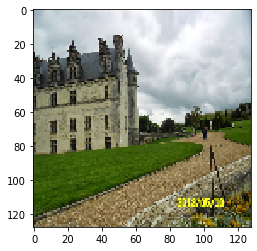

In [29]:
img_path = "test_50_class/000_395.jpg"

img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [30]:
pred = model_final.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3))[0].tolist()
pred_index = pred.index(max(pred))
print(mapping_dict[pred_index])
# print

395
